## Librairies

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

## Target : Analyse book loan trends of Parisian people and predict the number of loans per book

The number of loans may depend on:
- the book age
- the librairie and its stock,
- the author,
- the publisher (column Editeur)
- the format
This is what I will check 

## Dataset cleaning

In [2]:
dataBook=pd.read_csv('/Users/sandrine//Desktop/Prework/Projects_Ironhack/Book_loan/docprets.csv',sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataBook.head()

,N° de notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaclav Havel,Valeyre,Vandamme,Vaugirard,Auteur,Co-auteur,Auteur secondaire,Collectivité auteur,Collectivité auteur secondaire,Collectivité co-auteur
0,176870,NaN,NaN,NaN,français,La Politique étrangère en France | Texte impri...,NaN,Documentation française ;Ministère des affaire...,2003,386 p. | 28 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRANCE. Direction de la documentation française,France. Ministère des relations extérieures;Di...,NaN
1,176733,2-8435-2107-6,NaN,NaN,français,Voyages en Sicile | Texte imprimé | Dominique ...,NaN,"Diderot éditeur, arts et sciences",1998,1 vol. (299 p.) | 18 cm,...,NaN,NaN,NaN,NaN,"Denon, Dominique Vivant",NaN,NaN,NaN,NaN,NaN
2,176766,2-259-00278-1,NaN,NaN,français,0Voyages | [2] | Russie | Texte imprimé | Niko...,NaN,Plon,1977,322 p.-[1] f. de pl. | 20 cm,...,NaN,NaN,NaN,NaN,"Kazantzákīs, Níkos",NaN,"Princet, Liliane",NaN,NaN,NaN
3,176779,NaN,NaN,NaN,français,L'harmonica blues pour débutants | Texte imprimé,NaN,Emf,1997,1 méthode musicale (62 p.) | 30 cm | éventuell...,...,NaN,NaN,NaN,NaN,"Kinsella, Mick",NaN,NaN,NaN,NaN,NaN
4,176892,0-06-443063-4,NaN,NaN,anglais,A letter to Amy | Texte imprimé | Ezra Jack Keats,NaN,Harper Trophy,1984,30 p. | ill. en coul. | 21 cm,...,NaN,NaN,NaN,NaN,"Keats, Ezra Jack",NaN,NaN,NaN,NaN,NaN


In [4]:
#Check general info of dataset.
dataBook.shape,dataBook.dtypes

((815534, 103),
 N° de notice                        int64
 ISBN                               object
 ISSN                               object
 EAN                                object
 Langue                             object
                                     ...  
 Co-auteur                          object
 Auteur secondaire                  object
 Collectivité auteur                object
 Collectivité auteur secondaire     object
 Collectivité co-auteur             object
 Length: 103, dtype: object)

In [5]:
#Replace ' ' by '_in column names'
dataBook.columns=dataBook.columns.str.replace(' ','_')
#dataBook.columns.to_list()

In [6]:
dataBook['N°_de_notice'].unique().size==dataBook.shape[0]
#N°_de_notice could be an index for the dataset

True

In [7]:
# Prepare list of columns to drop due to missing values
to_drop=[]
to_drop.extend(dataBook.iloc[:,100:103].columns.to_list())
#Prepare list of columns for which we want to get dummies
Dummies_NA=[]
row_to_drop=[]

### Null values

In [8]:
#Check Number of Null values per columns
dataBook.isna().sum()

N°_de_notice                            0
ISBN                               323243
ISSN                               813046
EAN                                416532
Langue                              81024
                                    ...  
Co-auteur                          742302
Auteur_secondaire                  434716
Collectivité_auteur                778773
Collectivité_auteur_secondaire_    734515
Collectivité_co-auteur_            812309
Length: 103, dtype: int64

In [9]:
#Total number of Null values in the dataset
dataBook.isna().sum().sum()

62803925

### Author related columns 

In [10]:
#dataBook["Auteur_Dates"].value_counts()
#Column not necessary for the model so I drop it.
to_drop.append('Auteur_Dates')

In [11]:
#check whether I can drop or replace 'Auteur', 'Auteur Prenom' and 'Auteur Nom' columns
dftest=dataBook[(dataBook['Auteur_Nom']+', '+dataBook['Auteur_Prénom'])!=dataBook['Auteur']]
df=dftest[(dftest['Auteur_Nom']==dftest['Auteur'])|(dftest['Auteur_Prénom']==dftest['Auteur'])]
df[['Auteur_Nom','Auteur_Prénom','Auteur']]

df1=dftest[(dftest['Auteur_Nom']!=dftest['Auteur'])&(dftest['Auteur_Prénom']!=dftest['Auteur'])]
df1[['Auteur_Nom','Auteur_Prénom','Auteur']]
df1['Auteur_Prénom'].isna().sum()==df1['Auteur_Nom'].isna().sum()==df1['Auteur'].isna().sum()
#Author column is a mix of columns 'Auteur_Nom' and 'Auteur_Prénom' . However the format of Author does not
#suit me.

#check whether I can drop or replace 'Auteur_secondaire_Nom', 'Auteur_secondaire_Prénom' 
#and 'Auteur_secondaire' columns. Auteur secondaire include translaters.
#df3=dataBook[(dataBook['Auteur_secondaire_Nom']+', '+dataBook['Auteur_secondaire_Prénom'])!=dataBook['Auteur_secondaire']]
#df3[['Auteur_secondaire_Nom','Auteur_secondaire_Prénom','Auteur_secondaire']]
# same conclusions as for Author.

True

In [13]:
# Function to merge first name and last name in one column
def merge_authors(x):
    if ';' in x:
        y=x.split('|')
        z=[i for i in zip(y[0].split(';'),y[1].split(';'))]
        w=[' '.join(i) for i in z]
        return w
    else:
        w=x.replace("|", " ")
        return w
#test    
authors="Watson;Stephen;Padmore;Varcoe;Hickox,|Janice;Pamela Helen;Mark;Stephen;Richard"
test='Liliane|Princet'
y=merge_authors(authors)
y

['Watson Janice',
 'Stephen Pamela Helen',
 'Padmore Mark',
 'Varcoe Stephen',
 'Hickox, Richard']

In [14]:
#Creation of a new column for Author, Secondary Author,Co Author Author
def create_new_author(New_name,Firstname,Lastname):
    
    dataBook[New_name]=dataBook[Firstname]+'|'+dataBook[Lastname]
    dataBook[New_name].fillna('Unknown',inplace=True)
    dataBook[New_name]=dataBook[New_name].map(lambda x : merge_authors(x))
    to_drop.extend([Firstname,Lastname])
    return None


In [15]:
create_new_author('Author','Auteur_Prénom','Auteur_Nom')
create_new_author('Author_secondary','Auteur_secondaire_Prénom','Auteur_secondaire_Nom')
create_new_author('Co_Author','Co-auteur_Prénom','Co-auteur_Nom')

In [16]:
to_drop.extend(['Auteur','Co-auteur','Auteur_secondaire'])

In [17]:
dataBook["Auteur_secondaire_Dates"].value_counts()

19..-....                                                      3402
1946-....                                                      2451
1949-....                                                      2434
1952-....                                                      2382
1962-....                                                      2379
                                                               ... 
1937-....;1923-2011;1945-....;1930-....;1936-....;1928-2007       1
1935-1969;1923-1985                                               1
1915-1986;1909-2003;1925-....;1927-2007;1908-1968;1909-1995       1
1966-....;1973-....;1946-....;1971-....                           1
1881-1964;1920-2006                                               1
Name: Auteur_secondaire_Dates, Length: 37763, dtype: int64

In [18]:
#drop colum Auteur secondaire date after checking the  unique values of this columns
to_drop.append('Auteur_secondaire_Dates')

In [19]:
# column not necessary for the model and with to much null values

to_drop.extend(['Auteur_collectivité','Subdivision_auteur_collectivité','Co-auteur_collectivité','Subdivision_co-auteur_collectivité','Auteur_secondaire_collectivité','Subdivision_auteur_secondaire_collectivité'])



### Indice column

In [20]:
dataBook["Indice"].value_counts()

813                28346
843                27963
823                21361
741.56             15686
741.5               8804
                   ...  
917.294;390.097        1
709.59;730.959         1
200.1;306.6            1
064;944                1
949.72                 1
Name: Indice, Length: 32385, dtype: int64

In [21]:
to_drop.append('Indice')

### "Nombre de Localisations" column

In [22]:
#dataBook['Nombre_de_localisations'].value_counts()
dataBook[dataBook['Nombre_de_localisations'].isna()]

#after dropping row loc[283847]. this column should not have missing values anymore.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown


In [25]:
dataBook.drop(dataBook[dataBook['N°_de_notice']==891370].index,axis=0,inplace=True)

In [26]:
dataBook.Nombre_de_localisations=dataBook.Nombre_de_localisations.astype('int')

### "Nombre de Prêts" column

In [27]:
#dataBook['Nombre_de_prêt_total'].value_counts()
#dataBook[dataBook['Nombre_de_prêt_total']==6930.0].T.to_dict()
#dataBook[dataBook['Nombre_de_prêt_total'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018'].sum()
# put 0 when missing value for "Nombre de pret total after checking 2017 and 2018 values which are at 0"
dataBook['Nombre_de_prêt_total'].fillna('0',inplace=True)

In [28]:
# check if change is ok.
dataBook['Nombre_de_prêt_total'].isna().sum()

0

In [29]:
#dataBook['Nombre_de_prêts_2017'].value_counts()
#dataBook[dataBook['Nombre_de_prêts_2017']==1114.0].T.to_dict()
dataBook[dataBook['Nombre_de_prêts_2017'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018']
# put 0 when missing value for "Nombre de pret total after checking and 2018 values which are at 0"
dataBook['Nombre_de_prêts_2017'].fillna('0',inplace=True)

In [30]:
# check if change is ok.
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

In [31]:
dataBook['Nombre_de_prêts_2017']=dataBook['Nombre_de_prêts_2017'].astype('int')

### "Nombre d'exemplaires" column

In [32]:
#dataBook["Nombre_d'exemplaires"].value_counts()
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0 ].T.to_dict()
dataBook[dataBook["Nombre_d'exemplaires"].isna()]
# put 0 when missing value for 
dataBook["Nombre_d'exemplaires"].fillna('0',inplace=True)

In [33]:
# check if change is ok.
dataBook["Nombre_d'exemplaires"].isna().sum()

0

In [34]:
dataBook["Nombre_d'exemplaires"]=dataBook["Nombre_d'exemplaires"].astype('int')

### "Categories statistiques" columns

In [35]:
#dataBook["Catégorie_statistique_1"].value_counts().sum()
#dataBook[dataBook["Catégorie_statistique_1"].isna()]["Nombre_d'exemplaires"]
# no stock available==> drop the row
dataBook[dataBook["Catégorie_statistique_1"].isna()]

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,Unknown,Unknown,Unknown


In [36]:
#Row to drop by N°_de_notice
row_to_drop.extend([325759,128091])


In [37]:
dataBook["Catégorie_statistique_2"].value_counts()
# 688882 records without any specifique code stat 2.
# But  column can help to fill in missing values or error in other column
dataBook[dataBook["Catégorie_statistique_2"].isna()] 
# same rows to drop.


,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,Unknown,Unknown,Unknown


In [38]:
dataBook['Categories_stat']=dataBook.Catégorie_statistique_1

In [40]:
#Function to define new categories in a column based on the share of number of loans in 2017 . Below the threshold all the existing categories are grouped under "Other" category.
def GroupOther2(col,threshold):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(threshold)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [41]:
dataBook['Categories_stat']=GroupOther2('Catégorie_statistique_1',1)

In [42]:
#Number of categories reduced from 342 to 10
dataBook.Catégorie_statistique_1.nunique(),dataBook['Categories_stat'].nunique()

(342, 10)

### "Type de document" column

In [43]:
dataBook[dataBook["Type_de_document"].isna()]
# same row to drop.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author,Categories_stat
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,NaN


In [44]:
#Drop unecessary rows
dataBook.drop(dataBook[dataBook['N°_de_notice'].isin(row_to_drop)].index,axis=0,inplace=True)

In [45]:
dataBook["Type_de_document"].value_counts()

Livre pour adulte                              339488
Disque compact                                 189910
Livre jeunesse                                  86091
DVD-vidéo tous publics                          43654
Bande dessinée pour adulte                      27462
Livre en langue étrangère                       22714
Partition                                       19178
Bande dessinée jeunesse                         15219
Livre de Fonds spécialisés                      15001
DVD jeunesse                                     8788
Livre sonore pour adulte                         7119
Méthode de langue                                5751
Enregistrement musical pour la jeunesse          5095
Méthode musicale                                 3947
Usuels                                           3802
Livre en gros caractères                         3519
DVD- vidéo > 12 ans                              3256
Livre sonore jeunesse                            2943
Livre de section jeunesse > 

In [46]:
#Dictionnary used to create new categories for column "Type de document"
dict_map={'Livre pour adulte': 'Book',
 'Disque compact': 'CD',
 'Livre jeunesse': 'Book',
 'DVD-vidéo tous publics': 'DVD',
 'Bande dessinée pour adulte': 'BD',
 'Livre en langue étrangère': 'Book',
 'Partition': 'Partition',
 'Bande dessinée jeunesse': 'BD',
 'Livre de Fonds spécialisés': 'Book',
 'DVD jeunesse': 'DVD',
 'Livre sonore pour adulte': 'Book',
 'Méthode de langue': 'Other',
 'Enregistrement musical pour la jeunesse': 'CD',
 'Méthode musicale': 'Partition',
 'Usuels': 'Book',
 'Livre en gros caractères': 'Book',
 'DVD- vidéo > 12 ans': 'DVD',
 'Livre sonore jeunesse': 'Book',
 'Livre de section jeunesse > 12 ans': 'Book',
 'Vinyle': 'Vynile',
 'Carte ou plan': 'Map',
 'Revue pour adulte': 'Magazine',
 'Non empruntable': 'Cannot_be_borrowed',
 'DVD-vidéo > 16 ans':'DVD',
 'Livres et périodiques DAISY': 'Other',
 'Revue jeunesse': 'Magazine',
 'Diapositives jeunesse': 'Diapo',
 'Jeux Vidéos tous publics': 'Videogames',
 'Jeux de société': 'BoardGames',
 'Bande dessinée jeunesse >12 ans': 'Magazine',
 'Revue de Fonds spécialisés': 'Magazine',
 'Nouveauté': 'Book',
 'Nouveauté disque compact': 'CD',
 'Documents numériques et multimédia adulte': 'Other',
 'BD adulte non réservable': 'BD',
 'DVD- vidéo > 18 ans': 'DVD',
 'Jeux vidéos > 18 ans': 'Videogames',
 'Image, fiche cuisine …': 'Other',
 'Documents numériques et multimédia jeunesse': 'Other',
 'Adaptation en Langue des Signes Française': 'Other',
 'DVD nouveautés tous publics': 'DVD',
 'BD jeunesse non réservable': 'BD',
 'Instrument de musique': 'Musical instruments',
 'CD Rom revue': 'Other',
 'Nouveauté jeunesse': 'Book',
 'Revue pour ado': 'Magazine',
 'Cassette vidéo VHS tous publics': 'VHS',
 'Dossier': 'Other',
 'Cassette vidéo VHS > 12 ans': 'VHS',
 '2,00': 'to_drop'}

In [ ]:
#Check done for the mapping
#dataBook[dataBook["Type_de_document"]=='Nouveauté jeunesse'] ==> MANGAs
#dataBook[dataBook["Type_de_document"]=='Documents numériques et multimédia jeunesse'] ==>CD ROM
#dataBook[dataBook["Type_de_document"]=='Nouveauté'] ===> Book
#dataBook[dataBook["Type_de_document"]=='Non empruntable']['Nombre_de_prêts_2017'].sum()
#dataBook[dataBook["Type_de_document"]=='Enregistrement musical pour la jeunesse']

In [47]:
#New column with DocType ==> 
dataBook['DocType' ]=dataBook["Type_de_document"].map(dict_map)

In [48]:
#number of categories decrease from 49 to 15 with this mapping.
dataBook['Type_de_document' ].nunique(),dataBook['DocType' ].nunique()

(49, 15)

Text(0.5, 1.0, 'Number of loans per document type in 2017 (log)')

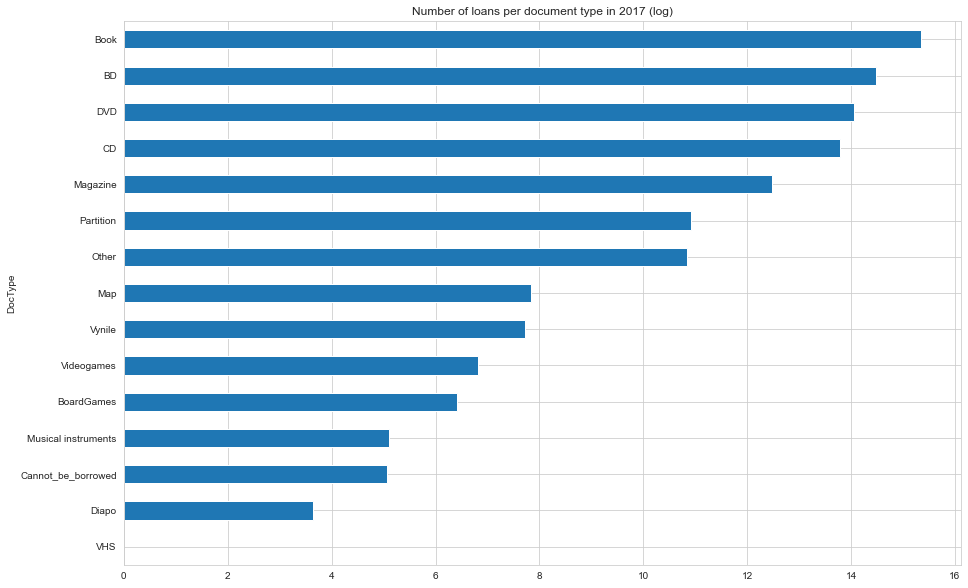

In [51]:
np.log(dataBook.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True)).plot(kind='barh',figsize=(15,10))

plt.title('Number of loans per document type in 2017 (log)')
# log used or the visualization as the number of loans for the books is much higher than the other categories

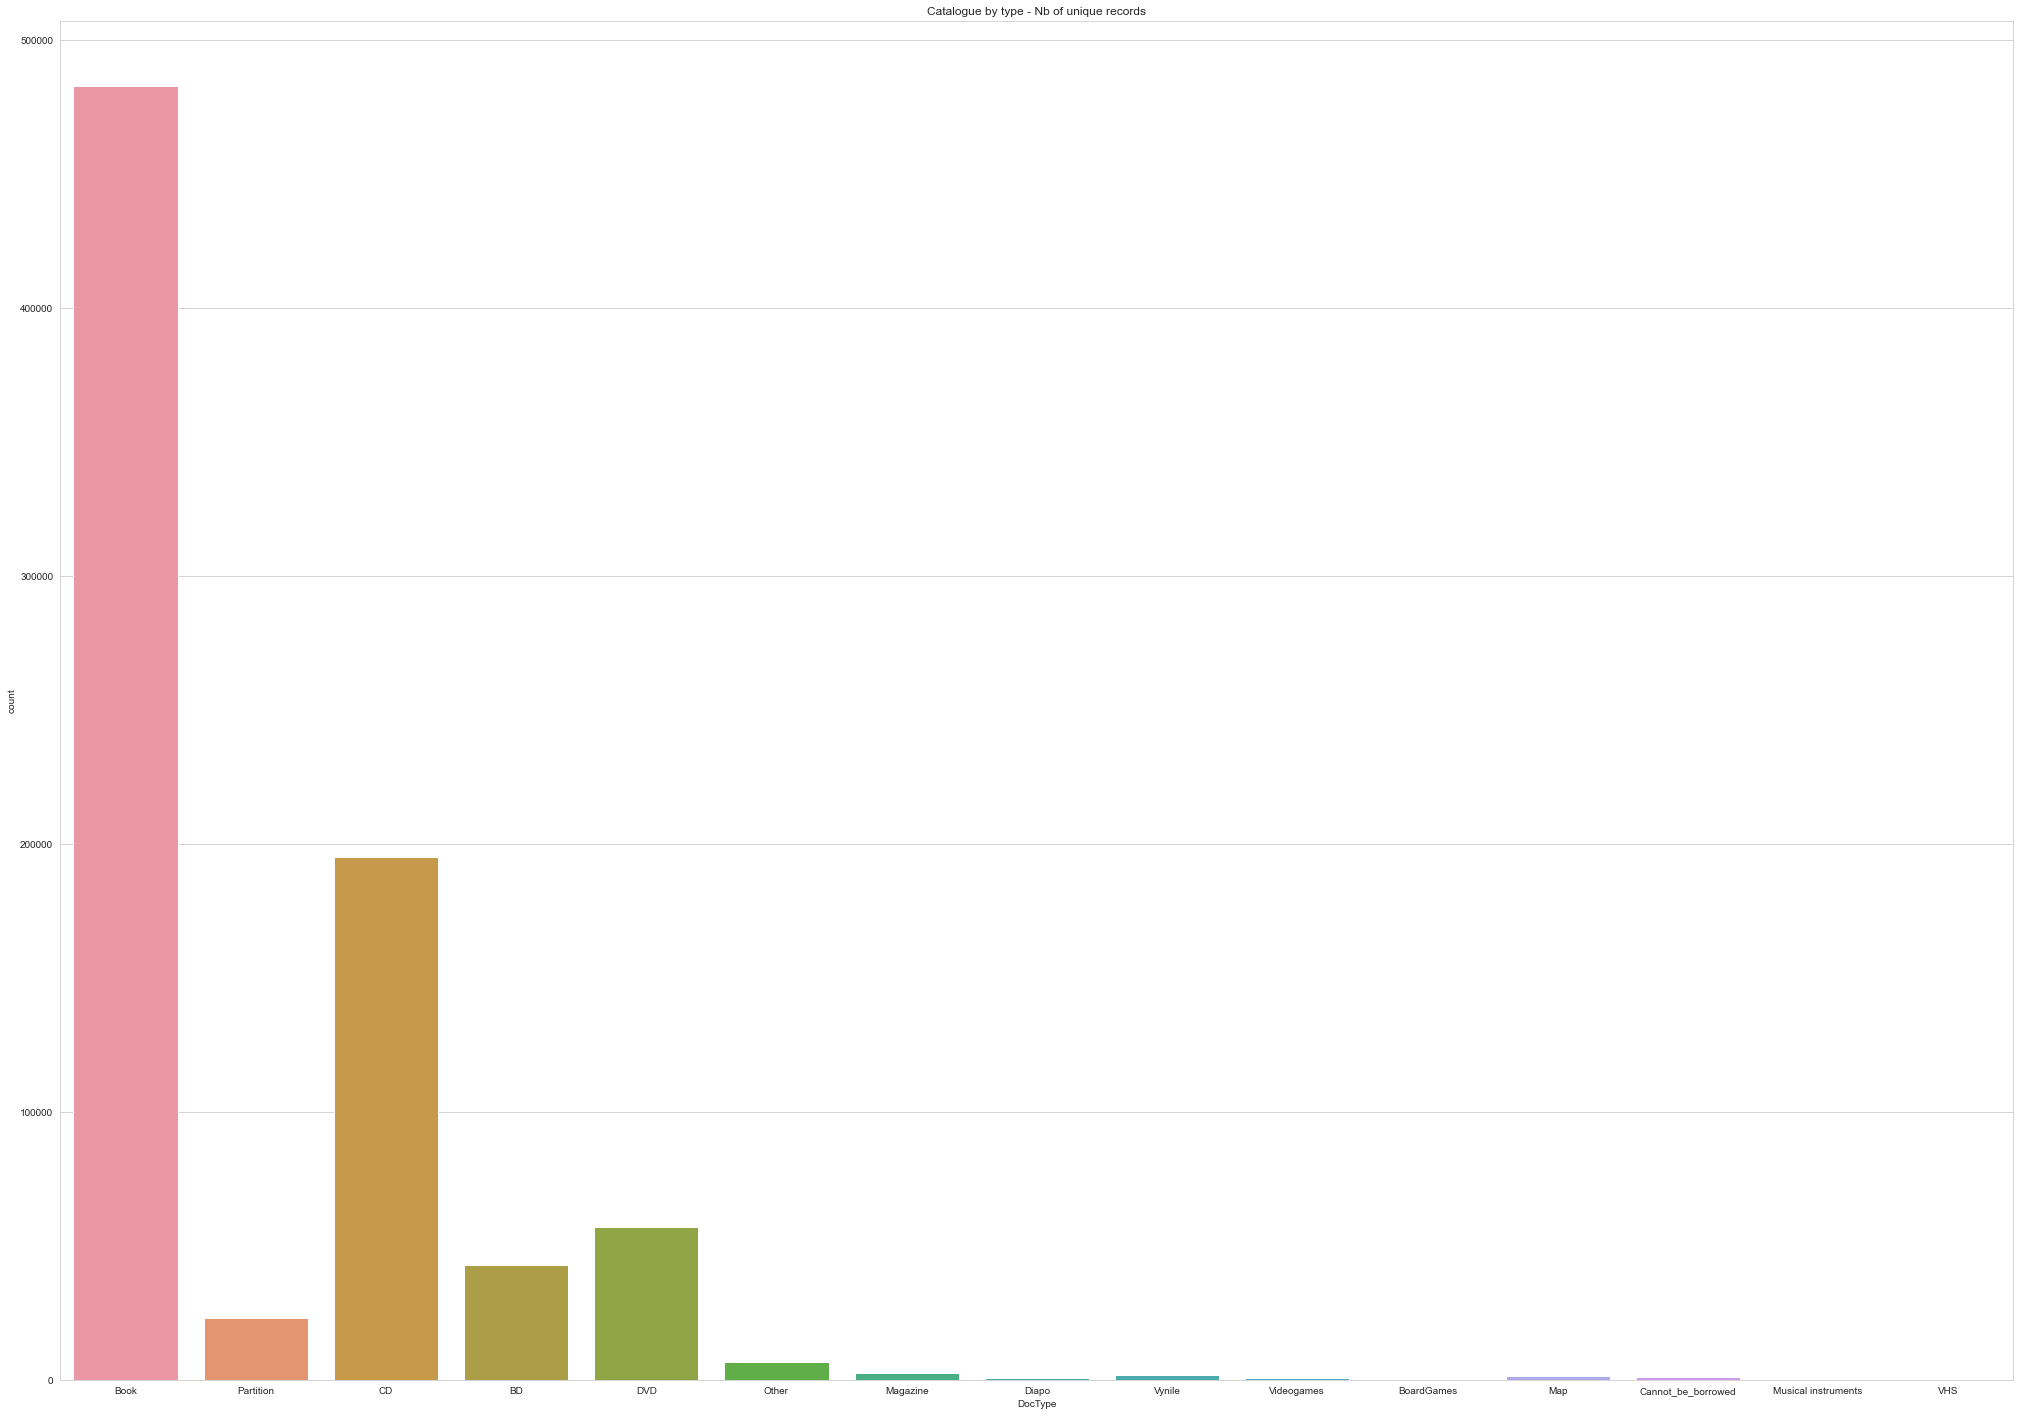

In [52]:
fig, ax = plt.subplots(figsize=(35,25))
sns.countplot(dataBook['DocType'])
plt.title('Catalogue by type - Nb of unique records')
plt.show()

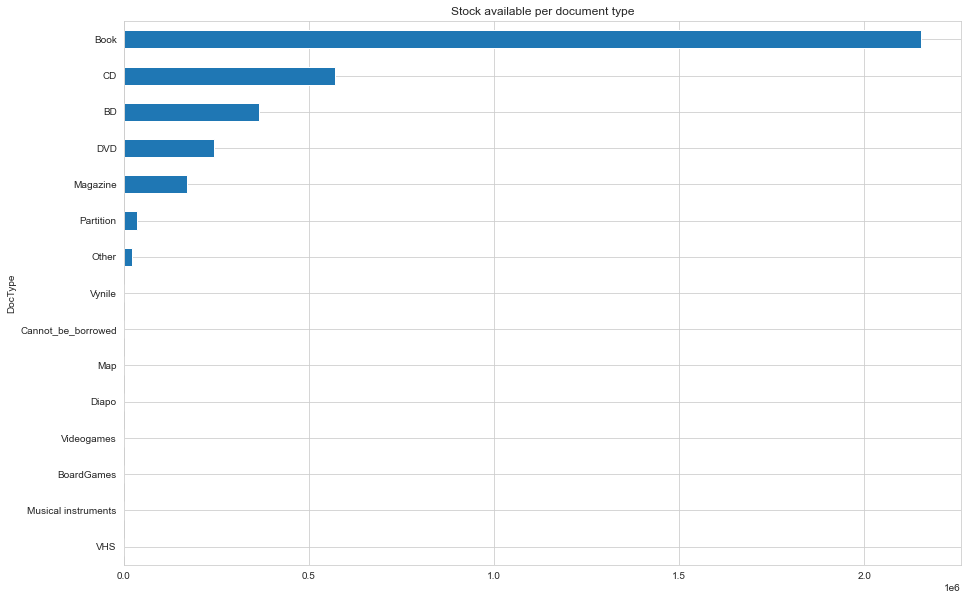

DocType
Book                   2152731
CD                      570734
BD                      363790
DVD                     242277
Magazine                169510
Partition                36064
Other                    23001
Vynile                    1659
Cannot_be_borrowed        1468
Map                       1356
Diapo                      923
Videogames                 739
BoardGames                 721
Musical instruments         25
VHS                          5
Name: Nombre_d'exemplaires, dtype: int64

In [53]:
# Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Stock available per document type')
plt.show()
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=False)

# TO DO :Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')


### Libraries columns

In [ ]:
"""Columns nb 38 to 97 are the stock of book available for each librairies 
Null values will be replaced by 0"""

In [54]:
# Replace null values in Librairies colums by 0 since Nan<=>'book title not in this librairy'
dataBook.iloc[:,38:97]=dataBook.iloc[:,38:97].fillna(0)

### "Date" column ==>Book age

In [55]:
#Look at the different types/format of info in Date columns
# Date give us more or less the age of the book (printing, edition,)
dataBook['Date'].value_counts().to_dict()

{'2004': 25126,
 '2017': 24924,
 '2003': 23471,
 '2002': 21567,
 '2001': 19751,
 '2000': 18409,
 '2005': 18177,
 '1999': 17394,
 '2012': 17081,
 '2006': 17042,
 '2016': 16909,
 '2007': 16603,
 '1998': 16184,
 '2011': 15227,
 '1997': 14965,
 '2015': 14721,
 '2013': 14272,
 '2014': 14250,
 '2008': 14098,
 '1996': 13789,
 '1995': 13665,
 '1994': 13337,
 '2010': 13291,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12172,
 '1993': 12131,
 '1991': 12121,
 '2009': 12069,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9292,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7528,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 'impr. 2006': 6247,
 '1985': 6196,
 'DL 2011': 6086,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '1982': 3976,
 'DL 20

In [56]:
#fill missing date with 'Unknown'
dataBook['Date'].fillna('Unknown',inplace=True)

In [57]:
#127 rows with a date containing "?":
dataBook[dataBook['Date'].str.contains("?",regex=False)].Date.value_counts().to_dict()
#I decide to clean  them

{'19-?': 765,
 '199?': 346,
 '198?': 240,
 '19??': 186,
 '200?': 144,
 '197?': 52,
 '18-?': 20,
 '192?': 14,
 '196?': 14,
 '189?': 12,
 '190?': 11,
 '195?': 10,
 '[197?]': 9,
 '[200?]': 8,
 '191?': 6,
 '20??': 6,
 '19 ?': 5,
 '20-?': 5,
 '188?': 5,
 '18??': 4,
 '[ca199?]': 4,
 '[198?]': 4,
 '[2006?]': 4,
 '2010 ?': 4,
 'P199?': 4,
 '198-?': 4,
 '[199?]': 3,
 '2005?': 3,
 '[2009?]': 3,
 '2004 ?': 3,
 '[2010?]': 3,
 'cop. 2001?': 3,
 '[201.?]': 3,
 '[ca 199?]': 3,
 '194?': 3,
 '193?': 3,
 '19?': 3,
 'P[199?]': 2,
 '200?-': 2,
 '201?': 2,
 '[ca19??]': 2,
 '[201?]': 2,
 '[2007?]': 2,
 '2008 ?': 2,
 '[20??]': 2,
 '1--?': 2,
 '1995?': 2,
 '[199?]-': 2,
 '1993?': 2,
 '[2004 ?]': 2,
 '18?-': 2,
 '199-?': 2,
 '[20..?]': 2,
 '[2014?]': 2,
 '[2015?]': 2,
 '2000?': 2,
 '2006 ?': 2,
 '2000 ?': 1,
 '[2016 ?]': 1,
 '1999?': 1,
 '[1977?]-': 1,
 '[19..?]': 1,
 '1991? 2001': 1,
 '2014;[2014 ?]': 1,
 '2012 ?': 1,
 'cop. 20??': 1,
 '[ca 200?]': 1,
 '2009 ?': 1,
 '[200.?]': 1,
 '1998?': 1,
 'P1994?': 1,
 '

In [58]:
#dictionnary to map date with "?". Ex: '199?' is replaced by a middle value 1995, '19-?' could be 1900 or 1990 so the info 
#is not useful. We put it as 'Unknown'
dct_date={'19-?': 'Unknown',
 '199?': '1995', 
 '198?': '1985',
 '19??': 'Unknown',
 '200?': '2005',
 '197?': '1975',
 '18-?': 'Unknown',
 '192?': '1925',
 '196?': '1965',
 '189?': '1895',
 '190?': '1905',
 '195?': '1955',
 '[197?]': '1975',
 '[200?]': '2005',
 '20??': 'Unknown',
 '191?': '1915',
 '20-?': 'Unknown',
 '19 ?': 'Unknown',
 '188?': '1885',
 '18??': 'Unknown',
 '[2006?]': '2006',
 '[ca199?]': 'Unknown',
 '[198?]': '1985',
 '198-?': '1985',
 '2010 ?': '2010',
 'P199?': '1995',
 '19?': 'Unknown',
 '[2009?]': '2009',
 '[201.?]': '2015',
 '194?': '1945',
 '[ca 199?]': '1995',
 '2004 ?': '2004',
 'cop. 2001?': '2001',
 '2005?': '2005',
 '[2010?]': '2010',
 '[199?]': '1995',
 '193?': '1935',
 '1993?': '1993',
 '[2004 ?]': '2004',
 '1995?': '1995',
 '[20..?]': 'Unknown',
 '[2007?]': '2007',
 '199-?': '1995',
 '2008 ?': '2008',
 '201?': '2015',
 '2000?': '2000',
 'P[199?]': '1995',
 '2006 ?': '2006',
 '[20??]': 'Unknown',
 '[2014?]': '2014',
 '[201?]': '2015',
 '1--?': 'Unknown',
 '200?-': '2005',
 '[2015?]': '2015',
 '[199?]-': '1995',
 '18?-': 'Unknown',
 '[ca19??]': 'Unknown',
 '[2013?]': '2013',
 '[2014 ?]': '2014',
 '[201.?)': '2015',
 '[1985 ?]': '1985',
 '[198 ?]': '1985',
 '[20??]-': 'Unknown',
 '2009 ?': '2009',
 '[2000?]': '2000',
 '2016?': '2016',
 '[196?]': '1965',
 '1934?': '1934',
 '?2001': '2001',
 '[2017?]': '2017',
 '[200.?]': '2005',
 '199?-': '1995',
 '19??-2011': 'Unknown',
 '[1977?]-': '1977',
 'Réed. 198?': '1985',
 '2000 ?': '2000',
 '[1998 ?]': '1998',
 '19_?': 'Unknown',
 'ca199?': 'Unknown',
 '[P199?]': '1995',
 '[197 ?]': '1975',
 '[2016?]': '2016',
 '1998?': '1998',
 'P19??': 'Unknown',
 '1980 ?': '1985',
 '198?6': '1986',
 '[1998?]': '1998',
 'P1988?': '1988',
 'ca 198?': '1985',
 '1958?': '1958',
 '[?1978]': '1978',
 'P1994?': '1994',
 '[2016 ?]': '2016',
 '[1985?]': '1985',
 '[2012?]': '2012',
 '[ca 201?]': '2015',
 '[2007?]-': '2007',
 '[ca 200?]': '2005',
 '2007?': '2007',
 '[201. ?]': '2015',
 '[2005?]': '2005',
 'cop. 20??': 'Unknown',
 '1994?': '1994',
 '1990?': '1990',
 '[1912?]': '1912',
 '[ca201?]': 'Unknown',
 '2010?': '2010',
 '[19..?]': 'Unknown',
 '19??-': 'Unknown',
 '[2011?]': '2011',
 '2008?': '2008',
 '[2004?]': '2004',
 '2002 ?': '2002',
 '[199-?]': '1995',
 'cop. 19??': 'Unknown',
 '[1997?]': '1997',
 '187?': '1875',
 '1999?': '1999',
 '1988?': '1988',
 '[2003?]-': '2003',
 '[2001?]': '2001',
 '[2...?]': 'Unknown',
 '1991? 2001': '1991',
 '1985? 2000': '1985',
 '[200-?]': '2005',
 '2014;[2014 ?]': '2014',
 '2012 ?': '2012'}

In [59]:
# Create a new column Date with the value of the dictionnary
dataBook['New_date']=dataBook['Date'].map(lambda x : x if x not in dct_date.keys() else dct_date[x])

In [60]:
dataBook['New_date'].value_counts().to_dict()

{'2004': 25132,
 '2017': 24925,
 '2003': 23472,
 '2002': 21568,
 '2001': 19756,
 '2000': 18413,
 '2005': 18338,
 '1999': 17395,
 '2012': 17083,
 '2006': 17048,
 '2016': 16912,
 '2007': 16607,
 '1998': 16187,
 '2011': 15228,
 '1997': 14966,
 '2015': 14733,
 '2013': 14273,
 '2014': 14254,
 '2008': 14101,
 '1995': 14032,
 '1996': 13789,
 '1994': 13339,
 '2010': 13299,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12173,
 '1993': 12133,
 '1991': 12122,
 '2009': 12073,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9294,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7529,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 '1985': 6451,
 'impr. 2006': 6247,
 'DL 2011': 6086,
 'Unknown': 5744,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '19

In [61]:
# Format of Date are pretty different. Some values are not even dates
#Action:correct date to Year only

#check if string contains a number
def hasNumbers(inputString):
    return bool(re.search(r'\d{4}', inputString))

# find all date or date like (finding digit)
def findDate(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return x

# find all date or date like (finding exactly 4 digits and take the first group of 4 digit)
def findDate2(x):
    if hasNumbers(x):
        date=re.findall(r'\d{4}',x)
    
        return date[0]
    else:
        return 'Unknown'


In [62]:
findDate2('P 2008 et cop. 2009')
findDate2('cop. 2002;30 cm')

'2002'

In [63]:
dataBook['New_date']=dataBook['New_date'].map(lambda x : findDate2(x))

In [64]:
dataBook['New_date'].value_counts(dropna=False).to_dict()

{'2013': 35252,
 '2012': 35205,
 '2007': 34106,
 '2010': 34024,
 '2008': 33851,
 '2011': 33649,
 '2014': 32897,
 '2009': 32803,
 '2006': 32100,
 '2015': 31810,
 '2005': 30569,
 '2016': 29998,
 '2004': 28409,
 '2017': 26161,
 '2003': 25411,
 '2002': 23069,
 '2001': 21371,
 '2000': 19826,
 '1999': 18671,
 '1998': 17282,
 '1997': 15883,
 '1995': 14891,
 '1996': 14657,
 '1994': 14261,
 '1992': 13464,
 '1990': 12977,
 '1993': 12945,
 '1991': 12936,
 '1989': 11415,
 '1988': 9794,
 '1987': 8745,
 '2018': 8586,
 'Unknown': 8543,
 '1986': 7880,
 '1985': 6745,
 '1984': 5667,
 '1983': 4695,
 '1982': 4160,
 '1980': 3901,
 '1981': 3890,
 '1979': 3484,
 '1978': 3087,
 '1977': 2700,
 '1976': 2439,
 '1975': 2118,
 '1973': 1988,
 '1974': 1882,
 '1972': 1849,
 '1971': 1722,
 '1970': 1667,
 '1969': 1537,
 '1968': 1459,
 '1967': 1371,
 '1966': 1150,
 '1965': 949,
 '1964': 913,
 '1963': 818,
 '1961': 717,
 '1962': 713,
 '1960': 577,
 '1959': 552,
 '1958': 533,
 '1957': 486,
 '1956': 474,
 '1955': 455,
 '19

In [65]:
#check records with dates >2018 (data supposed to be in till 2018)
dataBook[dataBook['New_date']=='2105']
#dataBook[dataBook['New_date']=='2019']

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author,Categories_stat,DocType,New_date
410382,1058113,978-604-1-06463-8,NaN,8934974134527,vietnamien,Ân Dô - miên dât huyên thoai và su thi | Texte...,NaN,NXB Trẻ,2105,1 vol. (225 p.) | couv. ill. en coul. | 20 cm,...,NaN,NaN,NaN,NaN,Huy Đỉnh Cao,Unknown,Unknown,Other,Book,2105


In [66]:
dct_date2={'2013': '2013',
 '2012': '2012',
 '2007': '2007',
 '2010': '2010',
 '2008': '2008',
 '2011': '2011',
 '2014': '2014',
 '2009': '2009',
 '2006': '2006',
 '2015': '2015',
 '2005': '2005',
 '2016': '2016',
 '2004': '2004',
 '2017': '2017',
 '2003': '2003',
 '2002': '2002',
 '2001': '2001',
 '2000': '2000',
 '1999': '1999',
 '1998': '1998',
 '1997': '1997',
 '1995': '1995',
 '1996': '1996',
 '1994': '1994',
 '1992': '1992',
 '1990': '1990',
 '1993': '1993',
 '1991': '1991',
 '1989': '1989',
 '1988': '1988',
 '1987': '1987',
 '2018': '2018',
 'Unknown': 'Unknown',
 '1986': '1986',
 '1985': '1985',
 '1984': '1984',
 '1983': '1983',
 '1982': '1982',
 '1980': '1980',
 '1981': '1981',
 '1979': '1979',
 '1978': '1978',
 '1977': '1977',
 '1976': '1976',
 '1975': '1975',
 '1973': '1973',
 '1974': '1974',
 '1972': '1972',
 '1971': '1971',
 '1970': '1970',
 '1969': '1969',
 '1968': '1968',
 '1967': '1967',
 '1966': '1966',
 '1965': '1965',
 '1964': '1964',
 '1963': '1963',
 '1961': '1961',
 '1962': '1962',
 '1960': '1960',
 '1959': '1959',
 '1958': '1958',
 '1957': '1957',
 '1956': '1956',
 '1955': '1955',
 '1954': '1954',
 '1951': '1951',
 '1947': '1947',
 '1953': '1953',
 '1952': '1952',
 '1950': '1950',
 '1948': '1948',
 '1949': '1949',
 '1946': '1946',
 '1925': '1925',
 '1931': '1931',
 '1930': '1930',
 '1927': '1927',
 '1929': '1929',
 '1945': '1945',
 '1934': '1934',
 '1937': '1937',
 '1932': '1932',
 '1928': '1928',
 '1938': '1938',
 '1935': '1935',
 '1926': '1926',
 '1936': '1936',
 '1933': '1933',
 '1942': '1942',
 '1924': '1924',
 '1939': '1939',
 '1941': '1941',
 '1943': '1943',
 '1923': '1923',
 '1921': '1921',
 '1944': '1944',
 '1922': '1922',
 '1910': '1910',
 '1911': '1911',
 '1920': '1920',
 '1940': '1940',
 '1912': '1912',
 '1900': '1900',
 '1875': '1875',
 '1913': '1913',
 '1893': '1893',
 '1904': '1904',
 '1909': '1909',
 '1874': '1874',
 '1907': '1907',
 '1877': '1877',
 '1892': '1892',
 '1895': '1895',
 '1908': '1908',
 '1888': '1888',
 '1839': '1839',
 '1915': '1915',
 '1905': '1905',
 '1919': '1919',
 '1889': '1889',
 '1876': '1876',
 '1914': '1914',
 '1898': '1898',
 '1845': '1845',
 '1885': '1885',
 '1891': '1891',
 '1897': '1897',
 '1878': '1878',
 '1887': '1887',
 '1899': '1899',
 '1836': '1836',
 '1918': '1918',
 '1917': '1917',
 '1916': '1916',
 '1879': '1879',
 '1903': '1903',
 '1906': '1906',
 '1867': '1867',
 '1896': '1896',
 '1901': '1901',
 '1894': '1894',
 '1882': '1882',
 '1886': '1886',
 '1902': '1902',
 '1870': '1870',
 '1851': '1851',
 '1883': '1883',
 '1857': '1857',
 '1880': '1880',
 '1890': '1890',
 '1821': '1821',
 '1866': '1866',
 '1884': '1884',
 '1881': '1881',
 '1873': '1873',
 '1864': '1864',
 '1854': '1854',
 '1869': '1869',
 '1861': '1861',
 '1855': '1855',
 '1859': '1859',
 '1846': '1846',
 '1868': '1868',
 '1860': '1860',
 '1862': '1862',
 '1856': '1856',
 '1865': '1865',
 '1840': '1840',
 '1830': '1830',
 '1844': '1844',
 '1863': '1863',
 '1838': '1838',
 '1853': '1853',
 '1828': '1828',
 '2019': '2009',
 '1872': '1872',
 '1843': '1843',
 '1850': '1850',
 '1849': '1849',
 '1822': '1822',
 '1848': '1848',
 '1829': '1829',
 '1837': '1837',
 '1858': '1858',
 '5774': '2014',
 '2088': 'Unknown',
 '2099': 'Unknown',
 '1871': '1871',
 '1847': '1847',
 '1825': '1825',
 '2066': 'Unknown',
 '1404': '1985',
 '5749': '1989',
 '2020': '2010',
 '1835': '1835',
 '2101': 'Unknown',
 '2104': 'Unknown',
 '8557': 'Unknown',
 '1818': '1818',
 '1192': 'Unknown',
 '3012': 'Unknown',
 '5765': 'Unknown',
 '9005': 'Unknown',
 '1809': '1809',
 '1823': '1823',
 '1831': '1831',
 '8201': '2010',
 '1834': '1834',
 '2047': 'Unknown',
 '1794': '1794',
 '3013': 'Unknown',
 '1820': '1820',
 '9729': '1993',
 '1801': '1801',
 '2105': 'Unknown',
 '1852': '1852',
 '2108': 'Unknown',
 '1817': '1817',
 '2021': '1896',
 '5738':'1978',
 '7500':'1989'}

In [67]:
# Map new dictionnary to the column 'New date'
dataBook['New_date']=dataBook['New_date'].map(dct_date2)

In [68]:
dataBook['New_date'].value_counts(dropna=False)

2013    35252
2012    35205
2007    34106
2010    34026
2008    33851
        ...  
1817        1
1794        1
1818        1
1801        1
1835        1
Name: New_date, Length: 198, dtype: int64

In [69]:
dataBook[dataBook['New_date']=='Unknown'].shape
#8558 records with an 'Unknown' date (out of more than 815000 records). We will drop these rows.

(8559, 109)

In [70]:
#Drop rows with 'Unknown' in column 'New_date'
index_to_drop=dataBook[dataBook['New_date']=='Unknown'].index
dataBook.drop(index_to_drop,inplace=True)

<AxesSubplot:xlabel='New_date'>

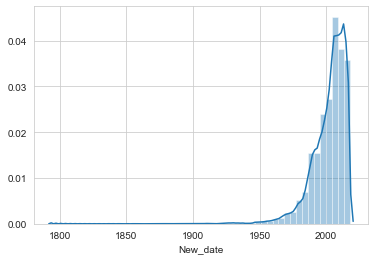

In [71]:
#Age distribution
sns.distplot(dataBook['New_date'])

In [72]:
# 'Age =2017-Date' ( I analyse the year 2017 so I calculate the age at that moment). I will remove the book with an age <0.
#(book published after 2017)
dataBook['Age']=dataBook['New_date'].map(lambda x : 2017-int(x))

In [73]:
#check if Age column is coherent (no null values, dtype =integer)
dataBook.Age.value_counts(dropna=False)

4      35252
5      35205
10     34106
7      34026
9      33851
       ...  
192        1
223        1
165        1
183        1
186        1
Name: Age, Length: 197, dtype: int64

In [74]:
dataBook.Age.median(),dataBook.Age.mean()

(12.0, 14.836430508121719)

In [75]:
# check if negative age and remove it.
dataBook[dataBook['Age']<0]['Nombre_de_prêts_2017'].sum()
#Negative Age should have 0 loan in 2017 . 5 loans==>probably a mistake. Given the amount, the quicker is to drop the rows.

5

In [76]:
dataBook.drop(dataBook[dataBook['Age']<0].index,inplace=True)

<AxesSubplot:xlabel='Age'>

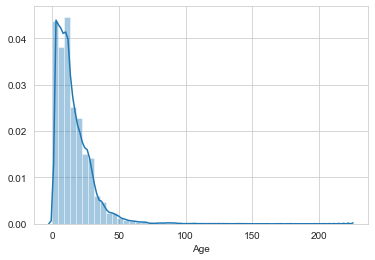

In [77]:
#Age distribution
sns.distplot(dataBook.Age)

### 'Langue' column

In [78]:
dataBook['Langue'].isna().sum()

78607

In [79]:
dataBook['Langue'].value_counts()

français                                548788
anglais                                  88421
sans                                     24557
multilingue                               8724
allemand                                  8123
                                         ...  
araméen d'empire (700-300 av. J.-C.)         1
fon                                          1
espéranto                                    1
sango                                        1
krou, langues                                1
Name: Langue, Length: 217, dtype: int64

In [80]:
#Replace null values with 'Unknown'
dataBook['Langue'].fillna('Unknown',inplace=True)


In [ ]:
#dataBook.groupby('Langue')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

In [81]:
#Create new columns Language
dataBook['Language']=dataBook['Langue']


In [82]:
dataBook['Language']=GroupOther2('Langue',0.10)


In [83]:
dataBook.Language=dataBook['Language'].str.replace('sans','Other')
dataBook.Language=dataBook['Language'].str.replace('langue indéterminée','Unknown')
dataBook.Language=dataBook['Language'].str.replace('multilingue','Other')

In [84]:
# Number of Languages categories reduced from 218 to 11
dataBook['Langue'].nunique(),dataBook['Language'].nunique()

(218, 11)

In [85]:
dataBook['Language'].value_counts(dropna=False).to_dict()

{'français': 548788,
 'anglais': 88421,
 'Unknown': 82154,
 'Other': 45766,
 'allemand': 8123,
 'italien': 8042,
 'espagnol': 6399,
 'chinois': 3919,
 'latin': 3107,
 'portugais': 2672,
 'japonais': 995}

In [86]:
#Rename categories in English
dct_lang={'français': 'French',
 'anglais': 'English',
 'Unknown': 'Unknown',
 'Other': 'Other',
 'allemand': 'German',
 'italien': 'Italian',
 'espagnol': 'Spanish',
 'chinois': 'Chinese',
 'latin': 'Latin',
 'portugais': 'Portuguese',
 'japonais': 'Japanese'}

In [87]:
dataBook['Language']=dataBook['Language'].map(dct_lang)

In [88]:
#Check if mapping did not generate null values
dataBook['Language'].isna().sum()

0

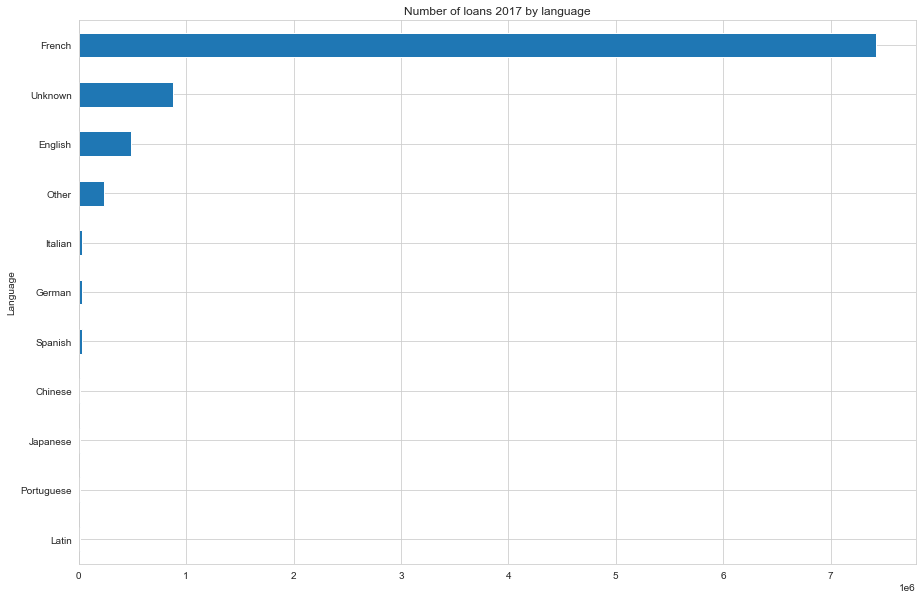

Language
French        7421924
Unknown        873922
English        483874
Other          231080
Italian         33299
German          26728
Spanish         26523
Chinese         13691
Japanese        11863
Portuguese      10901
Latin           10828
Name: Nombre_de_prêts_2017, dtype: int64

In [89]:

# Plot Number of loans by language
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Number of loans 2017 by language')
plt.show()

dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=False)


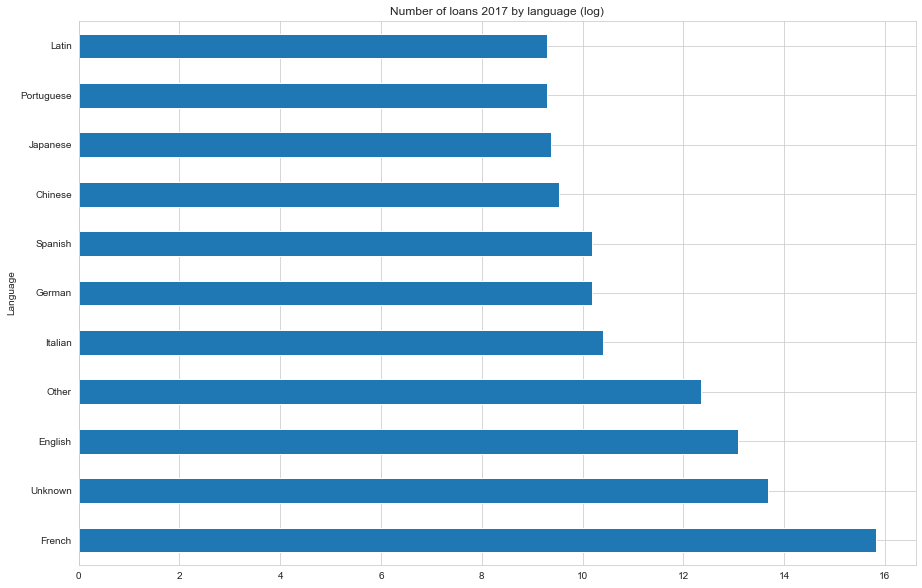

In [90]:
# Plot Number of loans by language (log)
np.log(dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=False)).plot(kind='barh',figsize=(15,10))
plt.title('Number of loans 2017 by language (log)')
plt.show()
# log used or the visualization as the number of loans for the French category is much higher than the other categories

### 'Edition' columns

In [91]:
dataBook['Edition'].value_counts()

Nouvelle édition                                                                               5710
Nouv. éd.                                                                                      3019
[Nouvelle éd.]                                                                                 2930
Choix de langues : français                                                                    2544
2e éd.                                                                                         2367
                                                                                               ... 
Choix de langues : néerlandais. Sous-titres : français. Certains dialogues sont en français       1
Choix de langues : français, iranien. Sous-titres: français                                       1
cop.1956                                                                                          1
Choix de langues : anglais, français, allemand, espagnol, italien. Sous-titres : 10 langues       1


In [92]:
dataBook['Editeur'].isna().sum()

3359

In [93]:
#Drop the Edition column as it does not seem to bring any major information 
#for the prediction of the loans and there are too many different categories.
to_drop.append('Edition')

### 'Editeur' columns

In [94]:
dataBook['Editeur'].value_counts()

Gallimard                                                                         26207
Flammarion                                                                        11069
Presses universitaires de France                                                   6061
A. Michel                                                                          5760
Fayard                                                                             5675
                                                                                  ...  
l'École des loisirs-[Minimax]                                                         1
Yeproc Records                                                                        1
Wild side video [éd.];Metro Goldwyn Mayer home entertainment France [distrib.]        1
Par Ici La Lumière Productions [éd.]                                                  1
GDM music                                                                             1
Name: Editeur, Length: 88081, dt

In [95]:
dataBook['Editeur'].isna().sum()

3359

In [96]:
dataBook['Editeur'].fillna('Unknown',inplace=True)

In [97]:
#same function but based on the frequency of the category.
def GroupOther(col):
    
    selection=(dataBook[col].value_counts(normalize=True)*100).lt(0.5)
    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [98]:
#selectop, depending on count of records
dataBook['Publisher']=dataBook['Editeur']
dataBook['Publisher']=GroupOther('Editeur')
    

In [99]:
dataBook['Publisher'].value_counts()

Other                               702847
Gallimard                            26207
Flammarion                           11069
Presses universitaires de France      6061
A. Michel                             5760
Fayard                                5675
Éd. du Seuil                          5128
Hachette                              4676
Nathan                                4549
Casterman                             4473
R. Laffont                            4471
Pocket                                4445
Librairie générale française          4435
Glénat                                4379
Actes Sud                             4211
Name: Publisher, dtype: int64

In [100]:
#Number of categories decreased from 88081 to 15
dataBook['Editeur'].nunique(),dataBook.Publisher.nunique()

(88081, 15)

In [ ]:
#the Editeur column has too many categories (more than 88000 to be used as it is) and each editeur represents
#a small share. ==> May use the unsupervised learning to cluster then predict.

### 'Format','Titre_de_série','N°','Dates','EAN','ISSN','New_Collection','Collection','Cote_majoritaire' columns


In [101]:
dataBook['Format'].value_counts()

1 disque compact | 1 brochure                                                                                                                                        22733
1 compact | 1 brochure                                                                                                                                               20814
1 disque compact | DDD | 1 brochure                                                                                                                                  20337
1 compact | DDD | 1 brochure                                                                                                                                         13101
1 compact | 1 dépliant                                                                                                                                                8136
                                                                                                                                                 

In [102]:
to_drop.append('Format')

In [103]:
dataBook['Collection'].value_counts()

Du monde entier                                 1560
Roman                                            893
Pour les nuls                                    696
Grands détectives                                674
Bouquins                                         613
                                                ... 
Un jour tout là-bas... | 1765-9914                 1
Département | 60                                   1
Petite bibliothèque Payot | 478                    1
Le Masque | Agatha Christie | 62 | 0768-1070       1
Toriko | 15;Shōnen                                 1
Name: Collection, Length: 172796, dtype: int64

In [104]:
dataBook['Collection'].isna().sum()

441121

In [ ]:
# Drop 'Collection' column: too many categories, too many null values ( more than half of the dataset)

In [105]:
dataBook['Titre_de_série'].value_counts()

L'Avant-scène théâtre                 349
L'Avant-Scène Théâtre                 277
Europe                                254
Textes et documents pour la classe    247
C'est pas sorcier                     240
                                     ... 
ApocalypseMania, cycle 2                1
Les romans de Marion et Charles         1
Pumzine                                 1
(Not her) Bible                         1
Owl Cave                                1
Name: Titre_de_série, Length: 22466, dtype: int64

In [106]:
dataBook['Titre_de_série'].isna().sum()

715932

In [ ]:
#same conclusion as for Collection.

In [107]:
dataBook['Dates'].value_counts(dropna=False)

NaN                                                  764329
1969-....                                               817
1970-....                                               717
1971-....                                               668
1959-....                                               659
                                                      ...  
1934-.... ;1947-....                                      1
1825-1864;1818-1883                                       1
19..-....;1929-2009                                       1
1877-1955;1928-....                                       1
1862-1918;1685-1750;1801-1835;1813-1883;1685-1759         1
Name: Dates, Length: 4895, dtype: int64

In [108]:
#same conclusion as for Collection.

In [109]:
dataBook['Cote_majoritaire'].value_counts(dropna=False)
# too many categories and no codebook available for this column.

'PER                                1256
'CHA                                1004
'MAR                                 884
'MAC                                 853
'BER                                 691
                                    ... 
'J BD EGA ADOS                         1
'J'AIME LIRE N° 474 JUILLET 2016       1
'F. LOCAL 846 SAI                      1
'MAGASIN N 13765                       1
NaN                                    1
Name: Cote_majoritaire, Length: 343473, dtype: int64

In [110]:
dataBook['ISSN'].value_counts(dropna=False)
#to drop (too many missing values)

NaN          795995
0395-6601       110
0045-1169        98
1161-3122        69
1261-4858        59
              ...  
1165-8045         1
1296-3844         1
1267-8066         1
0026-9166         1
0030-0500         1
Name: ISSN, Length: 985, dtype: int64

In [111]:
dataBook['EAN'].value_counts(dropna=False)
# too many categories and too many missing values

NaN              410579
3781605909000        63
3780532905505        59
3384442038140        37
3781605909505        35
                  ...  
9782756080437         1
9782081314504         1
9782867465512         1
3760122760066         1
0883870053228         1
Name: EAN, Length: 384564, dtype: int64

In [112]:
dataBook['N°'].value_counts(dropna=False)
#to drop (too many missing values)

NaN                                731301
1                                   12895
2                                   12031
3                                    7654
4                                    4544
                                    ...  
5, hiver                                1
1265                                    1
(deuxième trimestre 2008), n°23         1
819                                     1
Octobre 2017                            1
Name: N°, Length: 4249, dtype: int64

In [113]:
#dataBook['ISBN'].value_counts() # Not use except for looking for info on the web
#dataBook[dataBook['ISBN']=='9787530450123'] # Same ISBN for all the "tomes" ex: Encyclopedie

In [114]:
to_drop.extend(['Titre_de_série','N°','Dates','EAN','ISSN','Collection','Cote_majoritaire','N°_de_notice', 'ISBN', 'Langue', 'Date',
       'Type_de_document','Catégorie_statistique_1',
       'Catégorie_statistique_2','Nombre_de_prêt_année_2018_au_26_juillet_2018'])

In [115]:
dataBook.shape

(798386, 112)

In [116]:
#check columns to drop
to_drop

['Collectivité_auteur',
 'Collectivité_auteur_secondaire_',
 'Collectivité_co-auteur_',
 'Auteur_Dates',
 'Auteur_Prénom',
 'Auteur_Nom',
 'Auteur_secondaire_Prénom',
 'Auteur_secondaire_Nom',
 'Co-auteur_Prénom',
 'Co-auteur_Nom',
 'Auteur',
 'Co-auteur',
 'Auteur_secondaire',
 'Auteur_secondaire_Dates',
 'Auteur_collectivité',
 'Subdivision_auteur_collectivité',
 'Co-auteur_collectivité',
 'Subdivision_co-auteur_collectivité',
 'Auteur_secondaire_collectivité',
 'Subdivision_auteur_secondaire_collectivité',
 'Indice',
 'Edition',
 'Format',
 'Titre_de_série',
 'N°',
 'Dates',
 'EAN',
 'ISSN',
 'Collection',
 'Cote_majoritaire',
 'N°_de_notice',
 'ISBN',
 'Langue',
 'Date',
 'Type_de_document',
 'Catégorie_statistique_1',
 'Catégorie_statistique_2',
 'Nombre_de_prêt_année_2018_au_26_juillet_2018']

In [117]:
dataBook.to_csv('Dataset_clean_with_all_columns.csv')

In [118]:
# Remove the columns of to_drop
dataBook.drop(columns=to_drop,inplace=True)
#(798386, 112)==> (798386, 74)
#I kept the column "Titre",'Editeur' for analysis reasons

In [119]:
dataBook.shape


(798386, 74)

In [120]:
dataBook.to_csv('Dataset_clean_with_Title.csv')

In [121]:
df=dataBook.drop(columns=['Titre','Editeur'])

In [124]:
df.shape
#Initial number of rows=815534 decreased to 798386 (-17148rows:-2,1% of the records)
#Initial number of columns 103 decreased to 74 (-31 columns: -about 30% of the columns) with 59 columns which are the stocks of available for each document
# in each libraries and 2 rows to drop later when doing the modeling (Titre and editeur)
#((815534, 103)==>(798386, 72)
#

(798386, 72)